In [68]:
import os
HOME = os.getcwd()
print('HOME: ',HOME)

import json
import random
import pandas as pd
import sys
import lxml
import sklearn as sk
import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go



HOME:  /Users/ericsuardi/Desktop/DataMiningProject23-24


In [62]:
STANDARD_FILE = 'standard_medium.json'
ACTUAL_FILE = 'actual_medium.json'

In [63]:
# load standard and actual data
with open(os.path.join('data',STANDARD_FILE)) as f:
    standard = json.load(f)

with open(os.path.join('data', ACTUAL_FILE)) as f:
    actual = json.load(f)

# load the data into a dataframe
dfStandard = pd.DataFrame(standard)
dfActual = pd.DataFrame(actual)

# print head of the dataframes
print(dfStandard.head())
print(dfActual.head())

# get the unique cities and items of the standard data
cities = []
items = []
longestRoute = 0
shortestRoute = np.inf
for index, s in dfStandard.iterrows():
    #print(s)
    idS = s['id']
    route = s['route']
    for trip in route:
        cities.append(trip['from']) 
        items.extend(trip['merchandise'].keys())
    if len(route) > 0:
        cities.append(route[-1]['to'])
        
    if len(route) > longestRoute:
        longestRoute = len(route)
        
    if len(route) < shortestRoute:
        shortestRoute = len(route)

for index, s in dfActual.iterrows():
    #print(s)
    idS = s['id']
    route = s['route']
    for trip in route:
        cities.append(trip['from'])
        items.extend(trip['merchandise'].keys())
    if len(route) > 0:
        cities.append(route[-1]['to'])
        
    if len(route) > longestRoute:
        longestRoute = len(route)
    
    if len(route) < shortestRoute:
        shortestRoute = len(route)

# find the unique cities and items
uniqueCities = sorted(list(set(cities)))
uniqueItems = sorted(list(set(items)))

print("Unique cities: ", uniqueCities)
print("Unique items: ", uniqueItems)

print("Number of cities: ", len(uniqueCities))
print("Number of items: ", len(uniqueItems))

print("Longest route: ", longestRoute)
print("Shortest route: ", shortestRoute)


   id                                              route
0  s0  [{'from': 'Pisa', 'to': 'Cosenza', 'merchandis...
1  s1  [{'from': 'Grosseto', 'to': 'Syracuse', 'merch...
2  s2  [{'from': 'Varese', 'to': 'Aversa', 'merchandi...
3  s3  [{'from': 'Rimini', 'to': 'Naples', 'merchandi...
4  s4  [{'from': 'Castellammare di Stabia', 'to': 'Ci...
   id driver sroute                                              route
0  a0      J     s0  [{'from': 'Pisa', 'to': 'Cosenza', 'merchandis...
1  a1      J     s0  [{'from': 'Pisa', 'to': 'Cosenza', 'merchandis...
2  a2      E     s0  [{'from': 'Pisa', 'to': 'Cosenza', 'merchandis...
3  a3      B     s0  [{'from': 'Cosenza', 'to': 'Brindisi', 'mercha...
4  a4      B     s0  [{'from': 'Pisa', 'to': 'Cosenza', 'merchandis...
Unique cities:  ['Acerra', 'Afragola', 'Altamura', 'Andria', 'Avellino', 'Aversa', 'Bagheria', 'Benevento', 'Brindisi', 'Castellammare di Stabia', 'Catania', 'Civitavecchia', 'Corigliano-Rossano', 'Cosenza', 'Crotone', 'Faenza', 'Gi

In [64]:
def extractFeatureVector(df, uniqueCities, uniqueItems, longestRoute):
    # create a feature vector for each row
    featureVectors = []
    for index, row in df.iterrows():
        featureVector = [] 
        idS = row['id']
        route = row['route']
        for trip in route:
            # add the city of departure
            featureVector.append(uniqueCities.index(trip['from']))
            # add the city of arrival
            featureVector.append(uniqueCities.index(trip['to']))
            # add the items
            qntHotMerch = np.zeros(len(uniqueItems))
            for item, n in trip["merchandise"].items():
                qntHotMerch[uniqueItems.index(item)] = n
            #print(qntHotMerch)
            featureVector.extend(np.array(qntHotMerch.tolist()))
        # pad the feature vector with zeros
        while len(featureVector) < longestRoute * (2+len(uniqueItems)):
            featureVector.extend(np.zeros(2+len(uniqueItems)))
        featureVectors.append(featureVector)
    return featureVectors

In [78]:
# extract feature vectors from the data

standardVectors = extractFeatureVector(dfStandard, uniqueCities, uniqueItems, longestRoute)
actualVectors = extractFeatureVector(dfActual, uniqueCities, uniqueItems, longestRoute)
standardIds = dfStandard['id'].tolist()
actualIds = dfActual['sroute'].tolist()
#print("sroute: ", actualIds)

minRouteLength = np.min([len(route) for route in standardVectors] + [len(route) for route in actualVectors])
maxRouteLength = np.max([len(route) for route in standardVectors] + [len(route) for route in actualVectors])
print(standardVectors)
print("Min route length: ", minRouteLength)
print("Max route length: ", maxRouteLength)
        
standardVectors = np.array(standardVectors).astype(float)
actualVectors = np.array(actualVectors).astype(float)

# shape: (numRoutes, maxNumItems+2 (ie: from, to)))
print("standard shape", standardVectors.shape)
print("actual shape", actualVectors.shape)

assert standardVectors.shape[1] == actualVectors.shape[1], "The number of features is not the same between standard and actual data"
assert standardVectors.shape[1] == longestRoute * (2+len(uniqueItems)), "The number of features does not match the expected number, possibly due to a different longest route"

[[32, 13, 0.0, 17.0, 0.0, 11.0, 0.0, 1.0, 0.0, 16.0, 17.0, 0.0, 16.0, 8.0, 0.0, 15.0, 5.0, 0.0, 0.0, 27.0, 20.0, 29.0, 13, 8, 0.0, 12.0, 0.0, 16.0, 13.0, 0.0, 14.0, 0.0, 0.0, 12.0, 22.0, 18.0, 0.0, 14.0, 20.0, 3.0, 22.0, 0.0, 25.0, 0.0, 8, 48, 23.0, 4.0, 0.0, 0.0, 0.0, 0.0, 20.0, 20.0, 14.0, 30.0, 15.0, 0.0, 27.0, 0.0, 3.0, 20.0, 6.0, 23.0, 30.0, 17.0, 48, 37, 25.0, 0.0, 4.0, 20.0, 8.0, 10.0, 0.0, 24.0, 0.0, 0.0, 0.0, 8.0, 0.0, 25.0, 0.0, 0.0, 0.0, 13.0, 13.0, 5.0, 37, 25, 30.0, 9.0, 25.0, 25.0, 17.0, 9.0, 24.0, 19.0, 22.0, 12.0, 6.0, 1.0, 1.0, 5.0, 15.0, 0.0, 11.0, 24.0, 5.0, 7.0, 25, 47, 0.0, 0.0, 13.0, 14.0, 28.0, 0.0, 23.0, 25.0, 21.0, 1.0, 3.0, 14.0, 1.0, 11.0, 7.0, 16.0, 0.0, 21.0, 27.0, 21.0, 47, 26, 26.0, 22.0, 29.0, 29.0, 0.0, 7.0, 23.0, 5.0, 16.0, 2.0, 0.0, 7.0, 14.0, 7.0, 5.0, 0.0, 3.0, 13.0, 0.0, 24.0, 26, 5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 5, 44, 3.0, 0.0, 25.0, 22.0, 22.0, 0.0, 15.0, 12.0, 25.0, 12.0, 0.

In [79]:
# visualize the data in a 3D plot using TSNE, in red the standard data and in blue the actual data
tsne = TSNE(n_components=3, random_state=0, perplexity=5)

# stack the vectors and create a vector of types (0 for standard, 1 for actual)
stackedVectors = np.vstack((standardVectors, actualVectors))
print("stackedVectors shape", stackedVectors.shape)
types = np.hstack((np.zeros(standardVectors.shape[0]), np.ones(actualVectors.shape[0])))

# Fix the IndexError by using the stackedVectors instead of actualVectors for tsne.fit_transform()
vectorsTSNE = tsne.fit_transform(stackedVectors, types)

stackedVectors shape (2600, 1078)


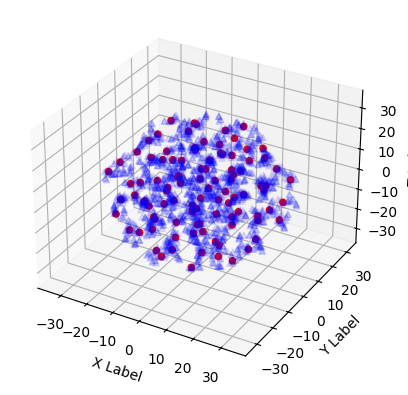

In [83]:
# plot the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(vectorsTSNE[types==0,0], vectorsTSNE[types==0,1], vectorsTSNE[types==0,2], c='r', marker='o', alpha=1)
ax.scatter(vectorsTSNE[types==1,0], vectorsTSNE[types==1,1], vectorsTSNE[types==1,2], c='b', marker='^', alpha=0.1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


# Create a color map that maps each unique label to a color
unique_labels = np.unique(standardIds)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))

# Use the color map to set the color of the markers
marker_colors = [color_map[label] for label in standardIds]

# Create a trace for each type
trace0 = go.Scatter3d(
    x=vectorsTSNE[types==0,0],
    y=vectorsTSNE[types==0,1],
    z=vectorsTSNE[types==0,2],
    mode='markers',
    marker=dict(
        size=7,
        color=marker_colors,                # set color to an array/list of desired values
        opacity=0.9,
        symbol='diamond'
    )
)


# Create a color map that maps each unique label to a color
unique_labels = np.unique(actualIds)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))

# Use the color map to set the color of the markers
marker_colors = [color_map[label] for label in actualIds]

trace1 = go.Scatter3d(
    x=vectorsTSNE[types==1,0],
    y=vectorsTSNE[types==1,1],
    z=vectorsTSNE[types==1,2],
    mode='markers',
    marker=dict(
        size=5,
        color=marker_colors,                # set color to an array/list of desired values
        opacity=0.3,
        symbol='circle'
    )
)

data = [trace0, trace1]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()